In [1]:
import pandas as pd

# Load your Parquet file
file_path = "../data/curated/map_features.parquet"
df = pd.read_parquet(file_path)

# Check the first few rows to ensure it's loaded correctly
print(df.head())

property_types = df['property_type'].unique()

# Print the distinct property types
print(property_types)


  postcode                                             name   latitude  \
0     3000         10/668 Bourke Street, Melbourne VIC 3000 -37.816589   
1     3000  1001/20-26 Coromandel Place, Melbourne VIC 3000 -37.813044   
2     3000     1001/23 Mackenzie Street, Melbourne VIC 3000 -37.807481   
3     3000      1003/118 Russell Street, Melbourne VIC 3000 -37.813500   
4     3000      1003/220 Spencer Street, Melbourne VIC 3000 -37.815695   

    longitude  distance_to_closest_school_km  distance_to_cbd   cost  \
0  144.954206                          0.959            1.399  559.0   
1  144.969255                          1.096            1.299  559.0   
2  144.967331                          0.464            1.062  559.0   
3  144.969088                          1.024            1.226  559.0   
4  144.952913                          1.197            1.638  559.0   

             property_type  beds  
0  Apartment / Unit / Flat   1.0  
1  Apartment / Unit / Flat   1.0  
2  Apartment / Un

In [7]:
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("Add Column from One Parquet to Another").getOrCreate()

# Load the two Parquet files
file1_path = "../data/raw/distances.parquet"
file2_path = "../data/raw/merged_df.parquet"

df1 = spark.read.parquet(file1_path)
df2 = spark.read.parquet(file2_path)

# Show schemas to understand the columns
df1.printSchema()
df2.printSchema()

df2_selected = df2.select("postcode", "cost", "property_type", "beds" )

# Join the two DataFrames on the key (e.g., 'id')
df_merged = df1.join(df2_selected, on="postcode", how="left")  # Use appropriate join type (e.g., 'inner', 'left')

# Show the merged DataFrame
df_merged.show()

# Remove duplicates based on 'postcode' and 'name' columns
df_merged = df_merged.dropDuplicates(['postcode', 'name'])

# Show the resulting DataFrame
df_merged.show()


# Save the merged DataFrame to a new Parquet file
output_file_path = "../data/curated/map_features.parquet"
df_merged.write.mode("overwrite").parquet(output_file_path)

print(f"Merged Parquet file with additional column saved to {output_file_path}")


root
 |-- name: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- distance_to_closest_school_km: double (nullable = true)
 |-- distance_to_cbd: double (nullable = true)

root
 |-- postcode: long (nullable = true)
 |-- cost: double (nullable = true)
 |-- suburb: string (nullable = true)
 |-- furnished: long (nullable = true)
 |-- property_type: string (nullable = true)
 |-- beds: double (nullable = true)
 |-- baths: double (nullable = true)
 |-- parking: long (nullable = true)
 |-- region: string (nullable = true)
 |-- lgaregion: string (nullable = true)
 |-- total male population - 2021: integer (nullable = true)
 |-- total female population - 2021: integer (nullable = true)
 |-- total population - 2021: integer (nullable = true)
 |-- australian citizens: integer (nullable = true)
 |-- median rent: integer (nullable = true)
 |-- median family weekly income: integer (nullable = true)
 |-

+--------+--------------------+-----------+-----------+-----------------------------+---------------+-----+--------------------+----+
|postcode|                name|   latitude|  longitude|distance_to_closest_school_km|distance_to_cbd| cost|       property_type|beds|
+--------+--------------------+-----------+-----------+-----------------------------+---------------+-----+--------------------+----+
|    3000|10/668 Bourke Str...|-37.8165887|144.9542063|                        0.959|          1.399|559.0|Apartment / Unit ...| 1.0|
|    3000|1001/20-26 Coroma...|-37.8130438|144.9692553|                        1.096|          1.299|559.0|Apartment / Unit ...| 1.0|
|    3000|1001/23 Mackenzie...|-37.8074807|144.9673314|                        0.464|          1.062|559.0|Apartment / Unit ...| 1.0|
|    3000|1003/118 Russell ...|-37.8134998|144.9690884|                        1.024|          1.226|559.0|Apartment / Unit ...| 1.0|
|    3000|1003/220 Spencer ...|-37.8156946|144.9529132|       

Merged Parquet file with additional column saved to ../data/curated/map_features.parquet


In [15]:
print(df.columns)

import folium

#(Melbourne CBD)
melbourne_cbd_coords = [-37.8136, 144.9631]


rental_map = folium.Map(location=melbourne_cbd_coords, zoom_start=7)


for index, row in df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Price: ${row['cost']}<br>Postcode: {row['postcode']}",  
        icon=folium.Icon(color='blue', icon='home')
    ).add_to(rental_map)

# Save map to an HTML file
output_map_path = "../data/plots/rental_properties_map.html"
rental_map.save(output_map_path)

print(f"Map saved to {output_map_path}")


Index(['postcode', 'name', 'latitude', 'longitude',
       'distance_to_closest_school_km', 'distance_to_cbd', 'cost',
       'property_type', 'beds'],
      dtype='object')
Map saved to ../data/plots/rental_properties_map.html


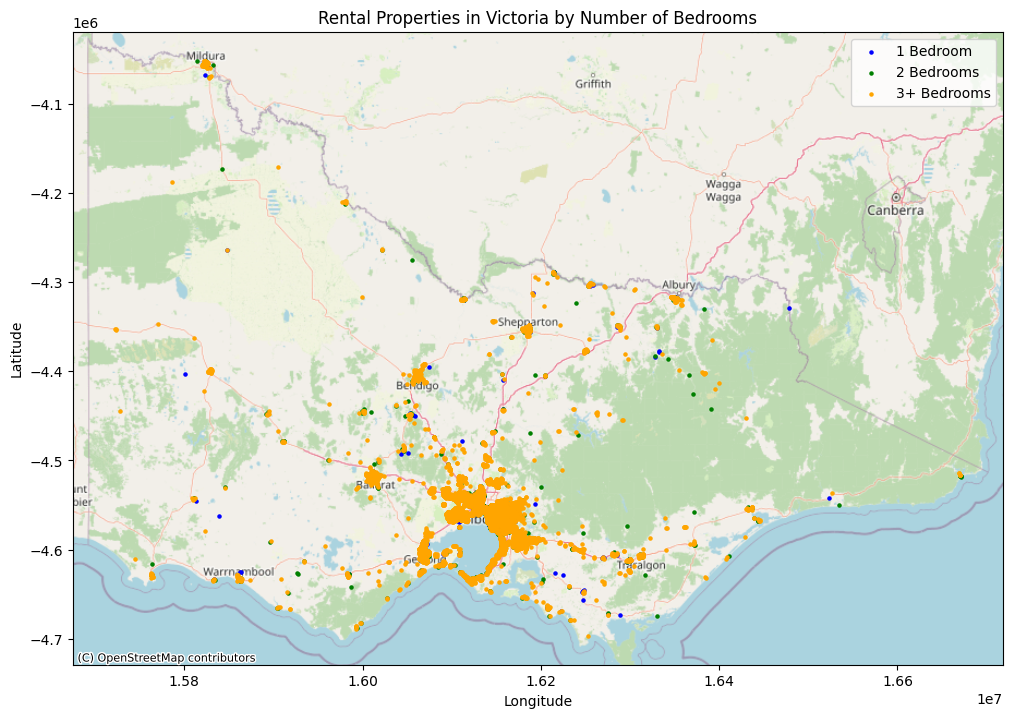

In [50]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx  # For adding OpenStreetMap base tiles


df = pd.read_parquet('../data/curated/map_features.parquet/')


df['beds'] = pd.to_numeric(df['beds'], errors='coerce')

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

# Reproject the GeoDataFrame to Web Mercator (EPSG:3857)
gdf = gdf.to_crs(epsg=3857)


fig, ax = plt.subplots(figsize=(12, 10))

# Define color for each room category
colors = {1: 'blue', 2: 'green', 3: 'orange'}

# Plot properties with 1 room in blue
gdf[gdf['beds'] == 1].plot(ax=ax, marker='o', color=colors[1], markersize=5, label='1 Bedroom')

# Plot properties with 2 rooms in green
gdf[gdf['beds'] == 2].plot(ax=ax, marker='o', color=colors[2], markersize=5, label='2 Bedrooms')

# Plot properties with 3 or more rooms in orange
gdf[gdf['beds'] >= 3].plot(ax=ax, marker='o', color=colors[3], markersize=5, label='3+ Bedrooms')

# Add OpenStreetMap base map for context
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)


plt.title('Rental Properties in Victoria by Number of Bedrooms')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Save the plot to a PNG file (optional)
# output_image_path = "../data/plots/rental_properties_by_rooms_map.png"
# plt.savefig(output_image_path, dpi=300)
# print(f"Map saved as PNG: {output_image_path}")

# Display the plot
plt.show()


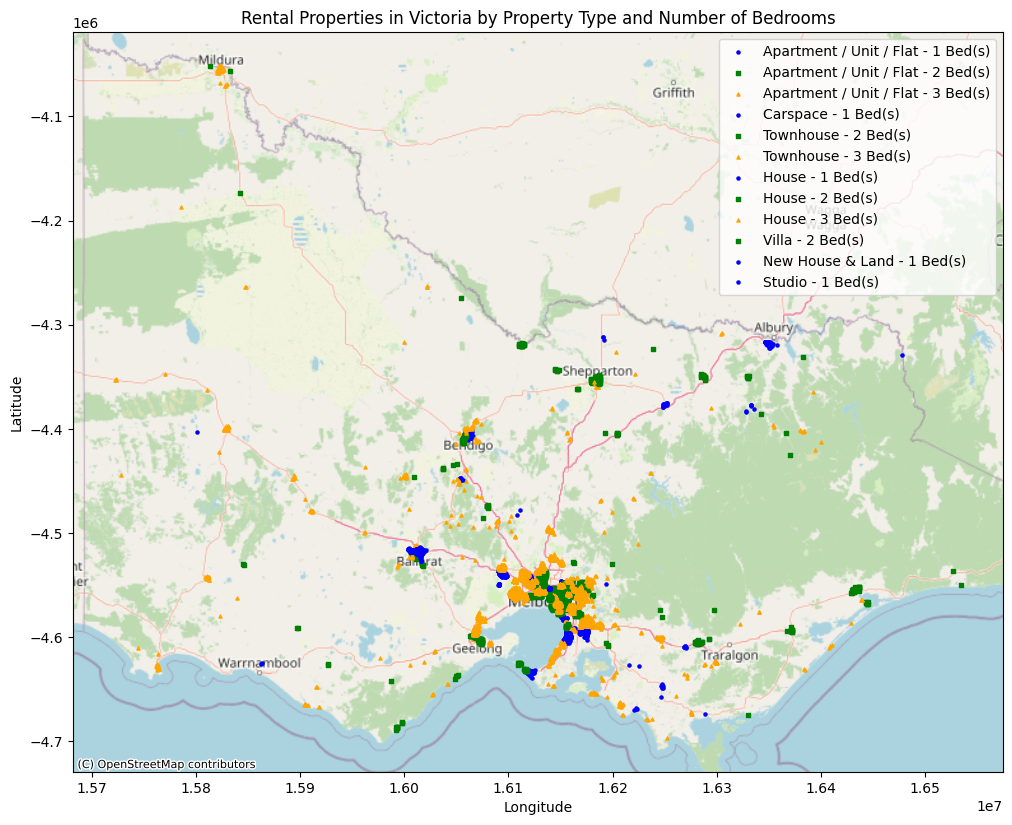

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx  # For adding OpenStreetMap base tiles
import numpy as np

# Load the properties data (replace with your file)
df = pd.read_parquet('../data/curated/map_features.parquet')

# Convert 'beds' to numeric
df['beds'] = pd.to_numeric(df['beds'], errors='coerce')

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

# Reproject the GeoDataFrame to Web Mercator (EPSG:3857), which is required for most web tile services
gdf = gdf.to_crs(epsg=3857)

# Get unique property types
unique_property_types = gdf['property_type'].unique()

# Generate a colormap with as many distinct colors as unique property types
cmap = plt.get_cmap('tab20', len(unique_property_types))  # tab20 provides 20 different colors, it will cycle if more needed

# Plot the properties on the map
fig, ax = plt.subplots(figsize=(12, 10))

# Loop through each unique property type
for i, property_type in enumerate(unique_property_types):
    color = cmap(i)  # Assign a unique color to each property type
    
    # Filter by property type
    gdf_filtered = gdf[gdf['property_type'] == property_type]
    
    # Loop for plotting each 'beds' type (1, 2, 3+)
    for bed_type, bed_color, marker in zip(
        [1, 2, 3],
        ['blue', 'green', 'orange'],
        ['o', 's', '^']  # different marker shapes for variety
    ):
        gdf_beds_filtered = gdf_filtered[gdf_filtered['beds'] == bed_type]
        
        # Only plot if there are properties with the current property type and bed type
        if not gdf_beds_filtered.empty:
            gdf_beds_filtered.plot(
                ax=ax,
                marker=marker,
                color=bed_color,
                markersize=5,
                label=f"{property_type} - {bed_type} Bed(s)"
            )

# Add OpenStreetMap base map for context
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add title, labels, and legend
plt.title('Rental Properties in Victoria by Property Type and Number of Bedrooms')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Save the plot to a PNG file (optional)
# output_image_path = "../data/plots/rental_properties_by_rooms_and_types_map.png"
# plt.savefig(output_image_path, dpi=300)
# print(f"Map saved as PNG: {output_image_path}")

# Display the plot
plt.show()
